<a href="https://colab.research.google.com/github/gokmenkilic/ML-Intro/blob/gk%2Ftests/Fusion_Plasma_Regression_solution.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>


# 0. The evolution of plasma state prediction

In this notebook, we attempt to build a Long short-term memory (LSTM) model to predict time series.

Thomson scattering is an important tool for plasma diagnostics in nuclear fusion facilities. Evolution of the Thomson Scattering data mapping the electron temperature and density of the profiles are predicted using an LSTM model. The model takes in the first 8 time instances of the profile and then maps the next 4 time instances. ​



In [2]:
# tensorflow
import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras.layers import Input, Dense
from tensorflow.keras.models import Model
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM
from tensorflow.keras.callbacks import EarlyStopping

# check version
print('Using TensorFlow v%s' % tf.__version__)
acc_str = 'accuracy' if tf.__version__[:2] == '2.' else 'acc'


# helpers
import os
import sys
import urllib.request
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib
from collections import Counter
from numpy import asarray as ar,exp
from sklearn.model_selection import train_test_split
from sklearn import mixture
from sklearn import cluster
from sklearn.decomposition import PCA
import pandas as pd
import os.path
import matplotlib.patches as mpatches
from sklearn.cluster import AgglomerativeClustering
from sklearn.cluster import MeanShift
import os
from IPython.display import clear_output
from tqdm import tqdm
import h5py
from os.path import join

# need some certainty in data processing
np.random.seed(1234)
tf.random.set_seed(1234)

data_path = 'data'


Using TensorFlow v2.19.0


## Data Setup & Google Colab Environment

The dataset is hosted publicly by DiRAC on COSMA. **Please make sure you run the cell below to download the data.**

To access the data from COSMA, you need to:

1. Run the first cell;
2. It will create a folder called sciml-workshop-data.
3. It will download the necessary HDF5 files directly into that folder.
4. Run the second cell and wait until the data folder appears.

If everything works correctly, a new folder called `sciml-workshop-data` should appear in the file browser on the left. Depending on the network speed, this may take one or two minutes. Ignore the warning "You do not appear to have access to project ...". If you are running the notebook locally or you have already connected to the bucket, these cells will have no side effects.

In [7]:
# data setup configuration
data_path = 'sciml-workshop-data'
full_dir = os.path.join(data_path, 'Fusion')
os.makedirs(full_dir, exist_ok=True)

base_url = "https://virgodb.cosma.dur.ac.uk/public/dc-kili1/sciml-workshop-data/Fusion/"
files_to_download = ["fusion_inputs.h5","fusion_targets.h5"]

In [8]:
for filename in files_to_download:
    path = os.path.join(full_dir, filename)

    if not os.path.exists(path):
        urllib.request.urlretrieve(base_url + filename, path)

# 1. Load the dataset

### Read in the Thomson scattering data

Use pandas to read the hdf 'Fusion/fusion_inputs.h5' and 'Fusion/fusion_targets.h5'. 'fusion_inputs.h5' includes six time series data: plasma current, toroidal mag field, z position, aspect ratio (major radius/minor radius), gas outboard and aux heat. 'fusion_targets.h5' includes electron density and electron temperature. All time series follow the same times and shot number

**Suggested Answer**

<details> <summary>Show / Hide</summary>
<p>
    
```python
with h5py.File(join(data_path, 'Fusion/fusion_inputs.h5'), 'r') as F:

    current_data = {}
    for i in range(len(np.array(F['current_data']))):
        current_data[i] = np.array(F['current_data'][str(i)])
        
    mag_data = {}
    for i in range(len(np.array(F['mag_data']))):
        mag_data[i] = np.array(F['mag_data'][str(i)])
    
    Z_data = {}
    for i in range(len(np.array(F['Z_data']))):
        Z_data[i] = np.array(F['Z_data'][str(i)])
    
    aspect_data = {}
    for i in range(len(np.array(F['aspect_data']))):
        aspect_data[i] = np.array(F['aspect_data'][str(i)])

    gas_data = {}
    for i in range(len(np.array(F['gas_data']))):
        gas_data[i] = np.array(F['gas_data'][str(i)])

    heat_data = {}
    for i in range(len(np.array(F['heat_data']))):
        heat_data[i] = np.array(F['heat_data'][str(i)])
        
        

with h5py.File(join(data_path, 'Fusion/fusion_targets.h5'), 'r') as F:

    shot_num = {}
    for i in range(len(np.array(F['shot_num']))):
        shot_num[i] = int(np.array(F['shot_num'][str(i)]))
        
    time_data = {}
    for i in range(len(np.array(F['time_data']))):
        time_data[i] = np.array(F['time_data'][str(i)])
    
    density_data = {}
    for i in range(len(np.array(F['density_data']))):
        density_data[i] = np.array(F['density_data'][str(i)])
    
    temperature_data = {}
    for i in range(len(np.array(F['temperature_data']))):
        temperature_data[i] = np.array(F['temperature_data'][str(i)])
```
    
</p>
</details>

In [9]:
with h5py.File(join(data_path, 'Fusion/fusion_inputs.h5'), 'r') as F:

    current_data = {}
    for i in range(len(np.array(F['current_data']))):
        current_data[i] = np.array(F['current_data'][str(i)])

    mag_data = {}
    for i in range(len(np.array(F['mag_data']))):
        mag_data[i] = np.array(F['mag_data'][str(i)])

    Z_data = {}
    for i in range(len(np.array(F['Z_data']))):
        Z_data[i] = np.array(F['Z_data'][str(i)])

    aspect_data = {}
    for i in range(len(np.array(F['aspect_data']))):
        aspect_data[i] = np.array(F['aspect_data'][str(i)])

    gas_data = {}
    for i in range(len(np.array(F['gas_data']))):
        gas_data[i] = np.array(F['gas_data'][str(i)])

    heat_data = {}
    for i in range(len(np.array(F['heat_data']))):
        heat_data[i] = np.array(F['heat_data'][str(i)])



with h5py.File(join(data_path, 'Fusion/fusion_targets.h5'), 'r') as F:

    shot_num = {}
    for i in range(len(np.array(F['shot_num']))):
        shot_num[i] = int(np.array(F['shot_num'][str(i)]))

    time_data = {}
    for i in range(len(np.array(F['time_data']))):
        time_data[i] = np.array(F['time_data'][str(i)])

    density_data = {}
    for i in range(len(np.array(F['density_data']))):
        density_data[i] = np.array(F['density_data'][str(i)])

    temperature_data = {}
    for i in range(len(np.array(F['temperature_data']))):
        temperature_data[i] = np.array(F['temperature_data'][str(i)])

In [10]:
e_temp = temperature_data
e_density = density_data

### combine signals into one stacked array for each

In [11]:
current_stack = np.hstack(list(current_data.values()))
mag_stack = np.hstack(list(mag_data.values()))
Z_stack = np.hstack(list(Z_data.values()))
aspect_stack = np.hstack(list(aspect_data.values()))
gas_stack = np.hstack(list(gas_data.values()))
heat_stack = np.hstack(list(heat_data.values()))

### Normalise each signal array by their maximum value

**Suggested Answer**

<details> <summary>Show / Hide</summary>
<p>
    
```python
current_stack = current_stack/np.max(current_stack)
mag_stack = mag_stack/np.max(mag_stack)
Z_stack = Z_stack/np.max(Z_stack)
aspect_stack = aspect_stack/np.max(aspect_stack)
gas_stack = gas_stack/np.max(gas_stack)
heat_stack = heat_stack/np.max(heat_stack)
```
    
</p>
</details>

In [12]:
current_stack = current_stack/np.max(current_stack)
mag_stack = mag_stack/np.max(mag_stack)
Z_stack = Z_stack/np.max(Z_stack)
aspect_stack = aspect_stack/np.max(aspect_stack)
gas_stack = gas_stack/np.max(gas_stack)
heat_stack = heat_stack/np.max(heat_stack)

### Combine all signals

In [13]:
all_signals = np.column_stack((current_stack,mag_stack,Z_stack,aspect_stack,gas_stack,heat_stack))
np.shape(all_signals)

(119727, 6)

### Create array of radial profiles (temperature and density) across all shots

In [14]:
temp_flat = []
for i in range(len(e_temp)):
    for j in range(len(e_temp[i])):
        temp_flat.append(e_temp[i][j])

density_flat = []
for i in range(len(e_density)):
    for j in range(len(e_density[i])):
        density_flat.append(e_density[i][j])

### Reshape array of radial profiles into 2D temporal/radial arrays for each shot

In [15]:
e_temp_reshaped = []
e_density_reshaped = []
b = []
a = 0
for i in range(len(e_temp)):
    b.append(a)
    b_sum = np.sum(b)
    a = len(e_temp[i])
    e_temp_reshaped.append(temp_flat[b_sum:a+b_sum])
    e_density_reshaped.append(density_flat[b_sum:a+b_sum])

### Combine density and temperature

In [16]:
new_temp = temp_flat/np.max(temp_flat) # normalise
new_density = density_flat/np.max(density_flat)
new_temp = np.reshape(new_temp,(len(new_temp),110,1))
new_density = np.reshape(new_density,(len(new_density),110,1))
target_all_flat = np.concatenate([new_temp,new_density],axis=2)
print(np.shape(target_all_flat))
training_shots_all = target_all_flat.reshape(len(target_all_flat),220)
print(np.shape(training_shots_all))

(119727, 110, 2)
(119727, 220)


In [17]:
def split_sequences(sequences, n_steps):
    X, y = list(), list()
    for i in range(len(sequences)):
        # find the end of this pattern
        end_ix = i + n_steps
        # check if we are beyond the dataset
        if end_ix > len(sequences)-1:
            break
        # gather input and output parts of the pattern
        seq_x, seq_y = sequences[i:end_ix, :], sequences[end_ix, :]
        X.append(seq_x)
        y.append(seq_y)
    return np.array(X), np.array(y)

### Split a multivariate sequence into samples using split_sequences

We will have a gap for a furture event prediction.

In [18]:
n_steps = 8
X, x1 = split_sequences(all_signals,n_steps) # X = training data, all_signals or all_signals_flat_test
print(np.shape(X))

(119719, 8, 6)


In [19]:
## delete end rows of training array depending on gap size
gap = 4
X = X[:-gap]
print(np.shape(X))

(119715, 8, 6)


In [20]:
## make target e_temp array
e_all_target = training_shots_all[n_steps+gap:] ## e_all_flat or training_shots_all
y = e_all_target.reshape(len(e_all_target),220) # use if training on all data
y = e_all_target ## use for surrogate dataset
print(np.shape(y))

(119715, 220)


# 2. Build the network

In this case, the inputs are time series of six features and outputs are electron density and electron temperature. We suggest to build a neural network using dense and lstm layers. In order to stack LSTM layers, return_sequences should be True.



**Suggested Answer**

<details> <summary>Show / Hide</summary>
<p>
    
```python
n_features = X.shape[2]

# define model
model = Sequential()
model.add(Dense(n_features, activation='relu', input_shape=(n_steps, n_features)))
model.add(Dense(n_features, activation='relu'))
model.add(LSTM(12, activation='relu', return_sequences=True))
model.add(layers.Dropout(0.2))
model.add(LSTM(24, activation='relu', return_sequences=True))
model.add(layers.Dropout(0.2))
model.add(LSTM(48, activation='relu', return_sequences=True))
model.add(layers.Dropout(0.2))
model.add(LSTM(100, activation='relu', return_sequences=True))
model.add(layers.Dropout(0.2))
model.add(LSTM(200, activation='relu'))
model.add(layers.Dropout(0.2))
model.add(Dense(220))
model.compile(optimizer='adam', loss='mse')
print(model.summary())
```
    
</p>
</details>


In [23]:
n_features = X.shape[2]

# define model
model = Sequential()
model.add(Dense(n_features, activation='relu', input_shape=(n_steps, n_features)))
model.add(Dense(n_features, activation='relu'))
model.add(LSTM(12, activation='relu', return_sequences=True))
model.add(layers.Dropout(0.2))
model.add(LSTM(24, activation='relu', return_sequences=True))
model.add(layers.Dropout(0.2))
model.add(LSTM(48, activation='relu', return_sequences=True))
model.add(layers.Dropout(0.2))
model.add(LSTM(100, activation='relu', return_sequences=True))
model.add(layers.Dropout(0.2))
model.add(LSTM(200, activation='relu'))
model.add(layers.Dropout(0.2))
model.add(Dense(220))
model.compile(optimizer='adam', loss='mse')
print(model.summary())

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_1 (Dense)                 │ (None, 8, 6)           │            42 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 8, 6)           │            42 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm (LSTM)                     │ (None, 8, 12)          │           912 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 8, 12)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 8, 24)          │         3,552 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 8, 24)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_2 (LSTM)                   │ (None, 8, 48)          │        14,016 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 8, 48)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_3 (LSTM)                   │ (None, 8, 100)         │        59,600 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 8, 100)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_4 (LSTM)                   │ (None, 200)            │       240,800 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 200)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 220)            │        44,220 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 363,184 (1.39 MB)

 Trainable params: 363,184 (1.39 MB)

 Non-trainable params: 0 (0.00 B)

None


### Train the model with EarlyStopping

**Suggested Answer**

<details> <summary>Show / Hide</summary>
<p>
    
```python
# fit model
stopper=EarlyStopping( monitor ="val_loss", min_delta=0.0,verbose=1,
                      mode="min",
                      restore_best_weights=True,patience=2)

history = model.fit(X, y, epochs=50, batch_size=256, shuffle=True, validation_split=1/12.,callbacks=[stopper])
```
    
</p>
</details>

In [24]:
# fit model
stopper=EarlyStopping( monitor ="val_loss", min_delta=0.0,verbose=1,
                      mode="min",
                      restore_best_weights=True,patience=2)

history = model.fit(X, y, epochs=50, batch_size=256, shuffle=True, validation_split=1/12.,callbacks=[stopper])

Epoch 1/50
429/429 ━━━━━━━━━━━━━━━━━━━━ 29s 34ms/step - loss: 5.0889e-04 - val_loss: 2.6094e-04
Epoch 2/50
429/429 ━━━━━━━━━━━━━━━━━━━━ 3s 8ms/step - loss: 3.0421e-04 - val_loss: 2.5324e-04
Epoch 3/50
429/429 ━━━━━━━━━━━━━━━━━━━━ 3s 8ms/step - loss: 2.8202e-04 - val_loss: 2.6078e-04
Epoch 4/50
429/429 ━━━━━━━━━━━━━━━━━━━━ 4s 9ms/step - loss: 2.6998e-04 - val_loss: 2.5318e-04
Epoch 5/50
429/429 ━━━━━━━━━━━━━━━━━━━━ 3s 8ms/step - loss: 2.6344e-04 - val_loss: 2.4612e-04
Epoch 6/50
429/429 ━━━━━━━━━━━━━━━━━━━━ 4s 9ms/step - loss: 2.5776e-04 - val_loss: 2.4806e-04
Epoch 7/50
429/429 ━━━━━━━━━━━━━━━━━━━━ 4s 9ms/step - loss: 2.5393e-04 - val_loss: 2.4254e-04
Epoch 8/50
429/429 ━━━━━━━━━━━━━━━━━━━━ 3s 8ms/step - loss: 2.4994e-04 - val_loss: 2.3787e-04
Epoch 9/50
429/429 ━━━━━━━━━━━━━━━━━━━━ 3s 8ms/step - loss: 2.4635e-04 - val_loss: 2.5273e-04
Epoch 10/50
429/429 ━━━━━━━━━━━━━━━━━━━━ 4s 8ms/step - loss: 2.4464e-04 - val_loss: 2.3747e-04
Epoch 11/50
429/429 ━━━━━━━━━━━━━━━━━━━━ 4s 8ms/step - lo

---

# 3. Analyse results

### Check training history

**Suggested Answer**

<details> <summary>Show / Hide</summary>
<p>
    
```python
# loss curves
plt.figure(figsize=(8,5))
plt.plot(history.history['loss'],linewidth=2.5)
plt.plot(history.history['val_loss'],linewidth=2.5)
plt.ylabel('Loss value',fontsize=14)
plt.xlabel('Epoch',fontsize=14)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.legend(['Training loss', 'Validation loss'], loc='upper right',fontsize=14)
plt.show()
```
    
</p>
</details>

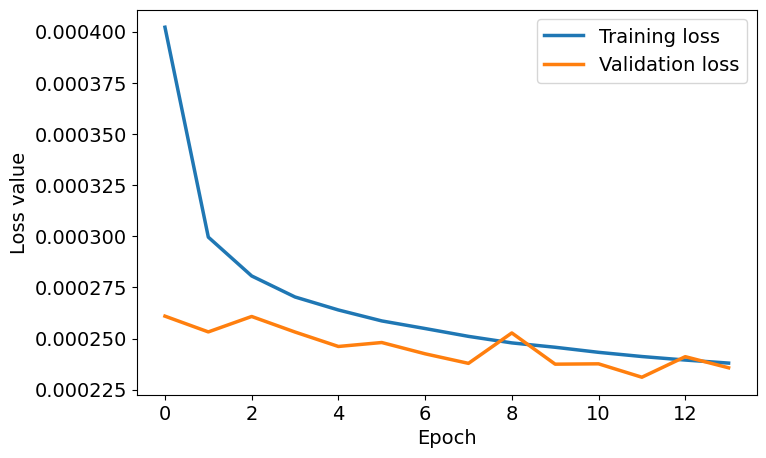

In [25]:
# loss curves
plt.figure(figsize=(8,5))
plt.plot(history.history['loss'],linewidth=2.5)
plt.plot(history.history['val_loss'],linewidth=2.5)
plt.ylabel('Loss value',fontsize=14)
plt.xlabel('Epoch',fontsize=14)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.legend(['Training loss', 'Validation loss'], loc='upper right',fontsize=14)
plt.show()

### Predict and compare errors

**Suggested Answer**

<details> <summary>Show / Hide</summary>
<p>
    
```python
y_pred = model.predict(X)
print(np.shape(y_pred))
```
    
</p>
</details>

In [26]:
y_pred = model.predict(X)
print(np.shape(y_pred))

3742/3742 ━━━━━━━━━━━━━━━━━━━━ 11s 3ms/step
(119715, 220)


In [27]:
## flattened array for comparison

e_all_compare = e_all_target[n_steps+gap:]
e_all_compare = e_all_compare.reshape(len(e_all_compare),220)
np.shape(e_all_compare)

(119703, 220)

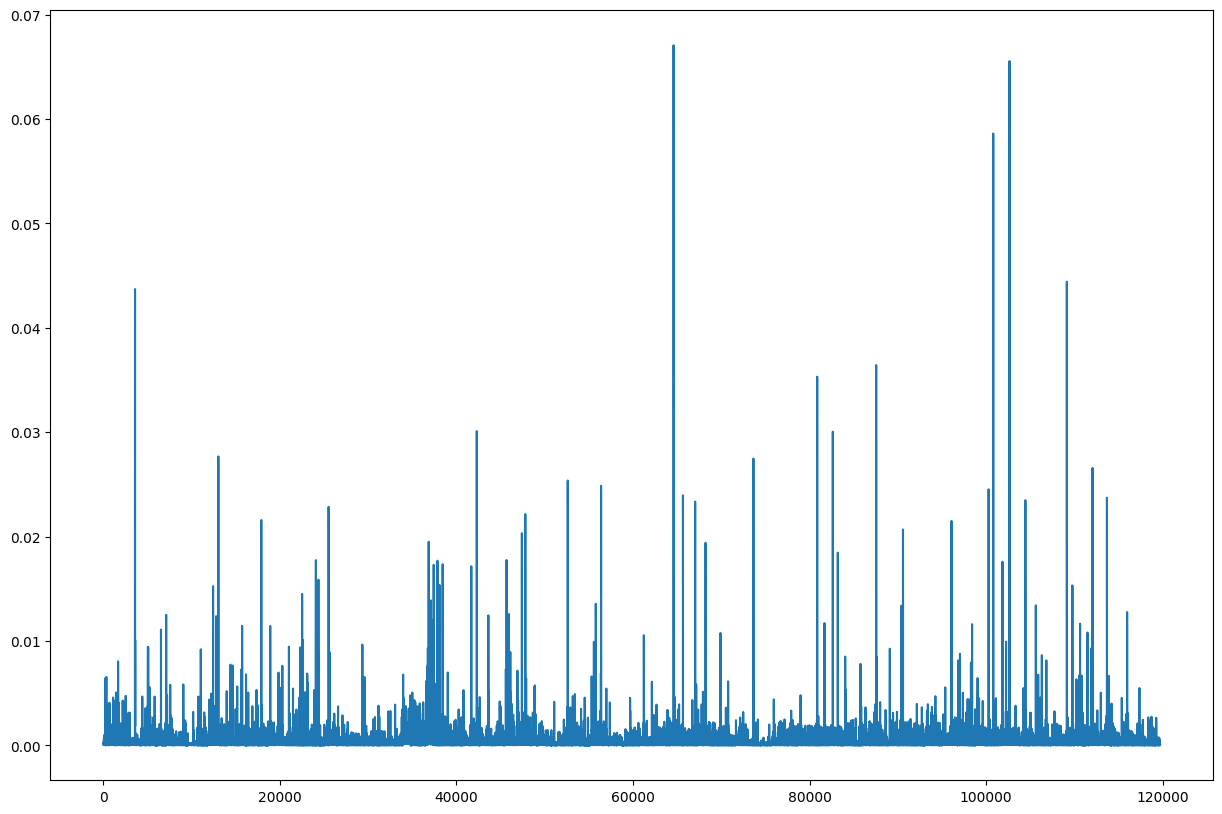

In [28]:
## compare to original decoded representation

errors = []
errors_t = []
errors_d = []

for i in range(0,len(e_all_compare)):
    subtract = (e_all_target[i] - y_pred[i])**2
    subtract_reshaped = subtract.reshape(110,2)

    mse = np.mean(subtract)
    subtract_mse_t = np.mean(subtract_reshaped[:,0])
    subtract_mse_d = np.mean(subtract_reshaped[:,1]) ## mse for density and temp

    errors.append(mse)
    errors_t.append(subtract_mse_t)
    errors_d.append(subtract_mse_d)

plt.figure(figsize=(15,10))
plt.plot(errors)

### Display the mean of errors of temeprature and density

**Suggested Answer**

<details> <summary>Show / Hide</summary>
<p>
    
```python
print(np.mean(errors_t)*100,'%') ##temp
print(np.mean(errors_d)*100,'%') ##density
```
    
</p>
</details>

In [29]:
print(np.mean(errors_t)*100,'%') ##temp
print(np.mean(errors_d)*100,'%') ##density

0.04186527 %
0.006223475 %


### Reshape array of predicted radial profiles into 2D temporal/radial arrays for each shot

In [30]:
y_pred = y_pred.reshape(len(y_pred),110,2)

temp_pred_reshaped = []
density_pred_reshaped = []
b = []
b1 = len(e_temp[0])-(n_steps+gap)
temp_pred_reshaped.append(y_pred[0:b1,:,0]*np.max(temp_flat)) ## *np.max(e_temp_flat) to un-normalise
density_pred_reshaped.append(y_pred[0:b1,:,1]*np.max(density_flat))
b.append(b1)
a = 0
for i in tqdm(range(1,len(e_temp))):
    b.append(a)
    b_sum = np.sum(b)
    a = len(e_temp[i])
    temp_pred_reshaped.append(y_pred[b_sum:a+b_sum,:,0]*np.max(temp_flat))
    density_pred_reshaped.append(y_pred[b_sum:a+b_sum,:,1]*np.max(density_flat))

100%|██████████| 1365/1365 [02:17<00:00,  9.90it/s]


shot number =  24366


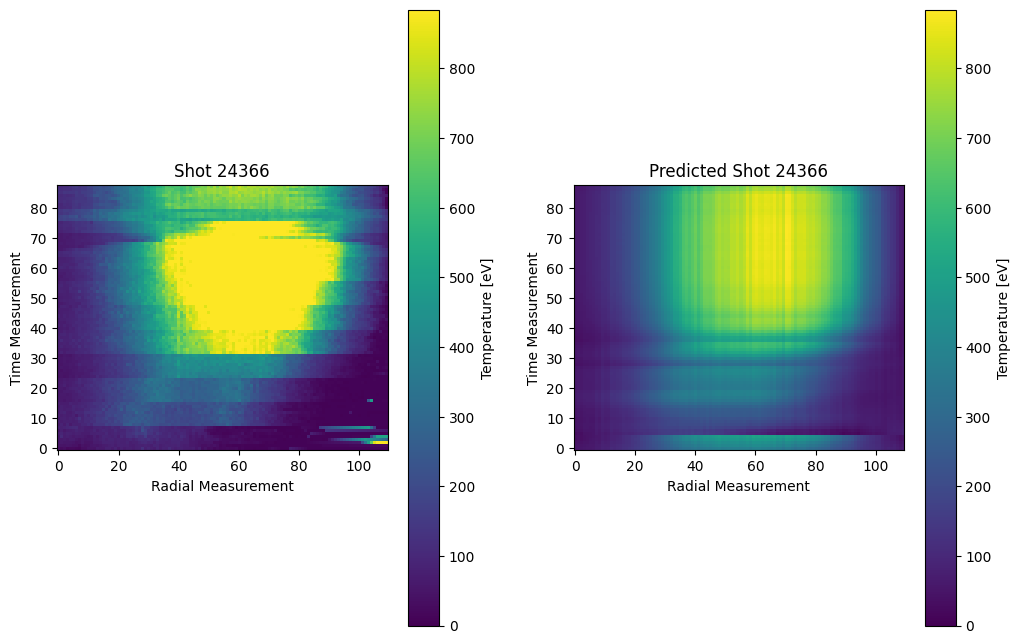

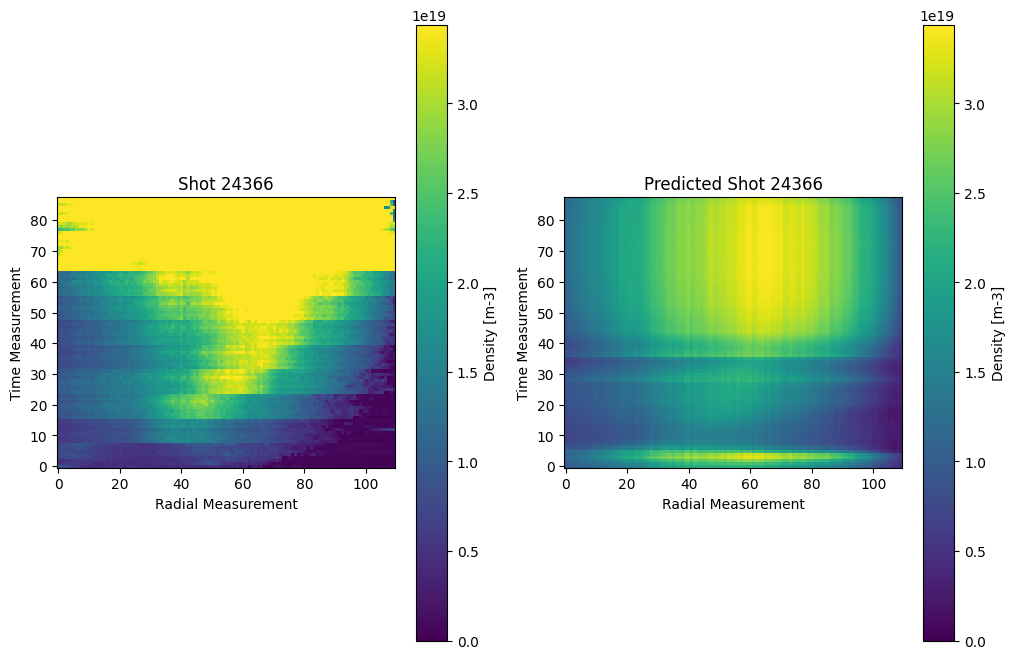

In [31]:
## compare predicted to original radial profiles (temperature)

# time vs. radius
from random import randrange
shot_index = randrange(len(shot_num))
print('shot number = ',shot_num[shot_index])

fig = plt.figure(figsize=(12,8))
fig.add_subplot(1,2,1)
plt.imshow(e_temp_reshaped[shot_index],vmin=0,vmax=np.max(temp_pred_reshaped[shot_index]),origin='lower')
plt.title('Shot '+str(shot_num[shot_index]))
plt.xlabel('Radial Measurement')
plt.ylabel('Time Measurement')
plt.colorbar(label='Temperature [eV]')

fig.add_subplot(1,2,2)
plt.subplots_adjust(wspace=0.25)
plt.imshow(temp_pred_reshaped[shot_index],vmin=0,vmax=np.max(temp_pred_reshaped[shot_index]),origin='lower')
plt.title('Predicted Shot '+str(shot_num[shot_index]))
plt.xlabel('Radial Measurement')
plt.ylabel('Time Measurement')
plt.colorbar(label='Temperature [eV]')

## compare predicted to original radial profiles (density)

# time vs. radius

fig = plt.figure(figsize=(12,8))
fig.add_subplot(1,2,1)
plt.imshow(e_density_reshaped[shot_index],vmin=0,vmax=np.max(density_pred_reshaped[shot_index]),origin='lower')
plt.title('Shot '+str(shot_num[shot_index]))
plt.xlabel('Radial Measurement')
plt.ylabel('Time Measurement')
plt.colorbar(label='Density [m-3]')

fig.add_subplot(1,2,2)
plt.imshow(density_pred_reshaped[shot_index],vmin=0,vmax=np.max(density_pred_reshaped[shot_index]),origin='lower')
plt.title('Predicted Shot '+str(shot_num[shot_index]))
plt.xlabel('Radial Measurement')
plt.ylabel('Time Measurement')
plt.colorbar(label='Density [m-3]')

---

# 4. Exercises

### Let's try doing some hyper-parameter tuning.  

* Different step sizes for time series data
* Different gap sizes
